In [242]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import gdown
import imageio
import matplotlib
from matplotlib import pyplot as plt

In [243]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam,legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [272]:
PATH = "./test.mpg"

In [273]:
import dlib

In [445]:
PREDICTOR_PATH = "/Users/shashwatkadadriya/Development/FinalYearProject/LipNetV1/LipNetV2/LipNet/shape_predictor_68_face_landmarks.dat"  # Download from Dlib's model zoo
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

def extract_lips(frame, margin=20):
    """
    Detect and extract the lip region from a single frame.
    
    Parameters:
        frame (np.array): A grayscale image frame.

    Returns:
        np.array: Cropped lip region.
    """
    # Detect faces in the frame
    faces = detector(frame, 0)

    if len(faces) == 0:
        return None  # No faces detected

    for face in faces:
            # Get facial landmarks
            landmarks = predictor(frame, face)
    
            # Nose tip (landmark 30) and chin (landmark 8)
            nose_tip = (landmarks.part(30).x, landmarks.part(30).y)
            chin = (landmarks.part(8).x, landmarks.part(8).y)
    
            # Calculate bounding box for the region below the nose
            x1 = min(landmarks.part(i).x for i in range(4, 13)) - margin  # Horizontal range of the lower face
            x2 = max(landmarks.part(i).x for i in range(4, 13)) + margin
            y1 = nose_tip[1] - margin
            y2 = chin[1] + margin
    
            # Ensure the coordinates are within frame boundaries
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(frame.shape[1], x2)
            y2 = min(frame.shape[0], y2)
    
            # Crop the region below the nose
            cropped_region = frame[y1:y2, x1:x2]
    
            return cropped_region
    
    return None


def load_video(path: str, target_frames: int = 75) -> tf.Tensor:
    """
    Load and preprocess a video to extract the lip region dynamically and match the model's input shape.

    Parameters:
        path (str): Path to the video file.
        target_frames (int): The fixed number of frames required by the model (default is 75).

    Returns:
        tf.Tensor: Tensor of shape (target_frames, 46, 140, 1), padded or truncated as needed.
    """
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Extract lips from the frame
        cropped_lips = extract_lips(gray, margin=20)

        if cropped_lips is None:
            continue  # Skip frames without lips detected

        # Resize cropped lips to (46, 140)
        resized_lips = cv2.resize(cropped_lips, (140, 46))

        # Add to frames
        frames.append(resized_lips)

    cap.release()

    if not frames:
        return tf.constant([])  # Return an empty tensor if no frames are processed

    # Normalize the frames (to [0, 1])
    frames = np.array(frames, dtype=np.float32) / 255.0

    # Add a channel dimension for grayscale (shape: [frames, 46, 140, 1])
    frames = np.expand_dims(frames, axis=-1)

    # Pad or truncate to match the required number of frames (target_frames)
    if len(frames) < target_frames:
        # Pad with zeros if frames are fewer than target_frames
        padding = np.zeros((target_frames - len(frames), 46, 140, 1), dtype=np.float32)
        frames = np.concatenate((frames, padding), axis=0)
    elif len(frames) > target_frames:
        # Truncate frames if they exceed target_frames
        frames = frames[:target_frames]

    # Ensure final shape is (target_frames, 46, 140, 1)
    return tf.convert_to_tensor(frames, dtype=tf.float32)



In [424]:
def load_video(path: str, target_frames: int = 75) -> tf.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Extract lips with an expanded margin
        cropped_lips = extract_lips(gray)

        if cropped_lips is None:
            continue  # Skip frames without lips detected

        # Resize the extracted lip region to (46, 140)
        resized_lips = cv2.resize(cropped_lips, (140, 46))

        frames.append(resized_lips)

    cap.release()

    if not frames:
        return tf.constant([])

    # Normalize frames to [0, 1]
    frames = np.array(frames, dtype=np.float32) / 255.0

    # Add a channel dimension (grayscale -> 1 channel)
    frames = np.expand_dims(frames, axis=-1)

    # Ensure the tensor shape is 5D: (1, depth, height, width, channels)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension

    # Pad or truncate to match the target number of frames
    if frames.shape[1] < target_frames:
        padding = np.zeros((1, target_frames - frames.shape[1], 46, 140, 1), dtype=np.float32)
        frames = np.concatenate((frames, padding), axis=1)
    elif frames.shape[1] > target_frames:
        frames = frames[:, :target_frames, :, :, :]

    return tf.convert_to_tensor(frames, dtype=tf.float32)



In [338]:
#Define the vocabulary as a list of all possible characters we may encounter in our annotations
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [339]:
# String to number mapping
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=vocab, oov_token=""
)

# Number to string mapping
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

# Print vocabulary information
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [340]:
def load_data(path: str):
    """
    Load data from the specified path

    Parameters:
        path (str): The path to the data file.

    Returns:
        Tuple[List[float], List[str]]: A tuple containing the loaded video frames and alignments.
    """
    # Convert path from bytes to string
    path = bytes.decode(path.numpy())

    # Extract file name from the path
    file_name = path.split('/')[-1].split('.')[0]

    # Construct paths for video and alignment files
    video_path = os.path.join('.', f'{file_name}.mpg')

    # Load video frames
    frames = load_video(video_path)

    return frames


In [341]:
def mappable_function(path: str) -> List[str]:
    """
    A mappable function to load data from the specified path.

    Parameters:
        path (str): The path to the data file.

    Returns:
        List[str]: A list containing the loaded video frames and alignments.
    """
    # Call load_data using tf.py_function
    result = tf.py_function(load_data, [path], tf.float32)

    return result

In [446]:
#Load the data and unpack the frame and alignments
frames = load_data(tf.convert_to_tensor(PATH))
# frames = tf.expand_dims(frames, axis=0)  # Shape: (1, 75, 46, 140, 1)


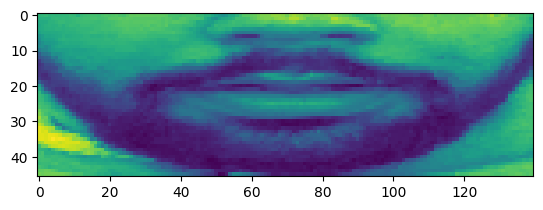

In [447]:
plt.imshow(frames[10])

In [251]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense

# Create a Sequential model
model = Sequential()

# Add a 3D convolutional layer with 128 filters, kernel size 3x3x3, and input shape of (75, 46, 140, 1)
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))

# Add ReLU activation function
model.add(Activation('relu'))

# Add 3D max pooling layer with pool size (1,2,2)
model.add(MaxPool3D((1,2,2)))

# Add another 3D convolutional layer with 256 filters and kernel size 3x3x3
model.add(Conv3D(256, 3, padding='same'))

# Add ReLU activation function
model.add(Activation('relu'))

# Add 3D max pooling layer with pool size (1,2,2)
model.add(MaxPool3D((1,2,2)))

# Add another 3D convolutional layer with 75 filters and kernel size 3x3x3
model.add(Conv3D(75, 3, padding='same'))

# Add ReLU activation function
model.add(Activation('relu'))

# Add 3D max pooling layer with pool size (1,2,2)
model.add(MaxPool3D((1,2,2)))

# Add TimeDistributed layer to apply Flatten operation to each time step independently
model.add(TimeDistributed(Flatten()))

#
Add Bidirectional LSTM layer with 128 units, using Orthogonal kernel initializer, returning sequences
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))

# Add dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))

# Add another Bidirectional LSTM layer with 128 units, using Orthogonal kernel initializer, returning sequences
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))

# Add dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))

# Add Dense layer with number of units equal to vocabulary size + 1, using he_normal kernel initializer and softmax activation function
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [252]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_9 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_10 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [253]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [254]:
# Assuming 'test' is your dataset
def preprocess_input(tensor, target_shape=(75, 46, 140, 1)):
    # Reshape or pad to match target shape if necessary
    # This assumes tensor has shape (75, None, None, None)
    tensor = tf.reshape(tensor, [-1, *target_shape])
    return tensor

def process_dataset(dataset):
    # Map the preprocessing function to adjust the first tensor to match input shape
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y))
    return dataset

# Apply the processing function to your dataset
processed_dataset = process_dataset(PATH)


AttributeError: 'str' object has no attribute 'map'

In [255]:
model.load_weights('models/checkpoint')

In [448]:
frames = tf.expand_dims(frames, axis=0)  # Shape: (1, 75, 46, 140, 1)
yhat = model.predict(frames)

1/1 [==============================] - 1s 714ms/step


In [462]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75])[0][0].numpy()

In [463]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'la re at fou ain wbp phe agin'>]

In [381]:
yhat

array([[[4.9353874e-04, 2.0822689e-02, 5.0585750e-02, ...,
         1.3939131e-06, 1.6041059e-02, 7.8169006e-04],
        [6.3266157e-04, 2.5051418e-01, 5.4597645e-03, ...,
         1.1866890e-06, 5.5272814e-02, 7.3925930e-04],
        [6.2066398e-04, 2.3596816e-01, 3.1744144e-03, ...,
         2.1262617e-06, 3.4767288e-01, 3.9505394e-04],
        ...,
        [4.2393067e-01, 2.5454585e-03, 1.2055571e-01, ...,
         1.2950366e-05, 1.2222825e-01, 5.2483954e-02],
        [8.0914199e-02, 3.9921398e-03, 3.6864787e-02, ...,
         3.5293233e-05, 1.9957042e-01, 1.8276300e-01],
        [8.5820451e-02, 1.8119465e-03, 2.4419017e-02, ...,
         1.5570227e-05, 5.2924973e-01, 1.2818190e-02]]], dtype=float32)